# Aim of the notebook

This notebook uses the list of all recorded accidents in the UK, downloaded from https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data, to create a machine Learning model that predicts the monthly accidents rate in the first 6 months of 2022 based on historical data.
The model is focused on the UK districts where accidents are more frequent. The district is identified using the geohash encoding (pygeohash Python library).

# Imports (modules and data)

In [2]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

# Custom modules with utility functions
from uk_road_safety.python.data_cleaning import prepare_data_for_groupby
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel


2023-01-03 13:32:07.207571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 13:32:07.883594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 13:32:07.883618: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 13:32:09.740939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
# Import the file downloaded from https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-1979-2021.csv
# and already fitered to only consider accidents from 1999 onwards
df_accidents=pd.read_csv('<path_to_file>', index_col=0)
df_accidents.head()

/tmp/ipykernel_3270/1438937949.py:3: DtypeWarning: Columns (1,3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
4883216,1999010SU0945,1999,010SU0945,519490.0,203300.0,-0.271752,51.715661,1,3,1,...,0,1,4,1,0,0,2,1,1,E01023583
4883217,1999010SU0946,1999,010SU0946,521740.0,201070.0,-0.239977,51.695136,1,3,2,...,0,6,4,1,0,0,2,1,1,E01023584
4883218,1999010SU0947,1999,010SU0947,519610.0,203240.0,-0.270037,51.715096,1,3,2,...,0,4,1,2,0,0,2,1,1,E01023583
4883219,1999010SU0948,1999,010SU0948,520090.0,202830.0,-0.263233,51.711309,1,2,2,...,0,6,1,1,0,0,2,1,1,E01023583
4883220,1999010SU0949,1999,010SU0949,522640.0,200320.0,-0.227225,51.688200,1,3,4,...,0,1,1,2,0,0,2,1,1,E01023584


In [4]:
# Prepare the raw data for the modeling
df_accidents=prepare_data_for_groupby(df_accidents,6)

In [5]:
# Save the preprocessed data for future use
df_accidents.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')

In [6]:
df_accidents.head()

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,IsWeekend,month,Daytime,geohash
4883216,1999,-0.271752,51.715661,3,1,1,1999-12-25,7,09:30,False,12,morning rush (5-10),gcpy1y
4883217,1999,-0.239977,51.695136,3,2,1,1999-12-17,6,18:38,False,12,afternoon rush (15-19),gcpy4d
4883218,1999,-0.270037,51.715096,3,2,2,1999-12-15,4,18:04,False,12,afternoon rush (15-19),gcpy1y
4883219,1999,-0.263233,51.711309,2,2,1,1999-12-02,5,04:10,False,12,night (23-5,gcpy4j
4883220,1999,-0.227225,51.688200,3,4,3,1999-12-04,7,09:51,False,12,morning rush (5-10),gcpy4c


# First Geohash gcpvj0

In [7]:
# Generate the list of all geohashes ordered by accidents counts (since 1999)
hashes=df_accidents[['geohash','accident_year']].groupby('geohash').count()
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)

In [8]:
hashes.head()

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744


In [9]:
# Isolating the geohash with most accidents
max_hash=hashes.index[0]
max_hash

'gcpvj0'

In [10]:
# Filtering the data to consider only accidents occurred in the max_hash
test_max_square=df_accidents[df_accidents['geohash']==max_hash]

# Preparing the data as a time series measuring the counts of accidents occurred month by month 
time_series_gcpvj0=data_for_analysis(test_max_square,'M')
time_series_gcpvj0.head(20)

,Accidents
date,
1999-01-31,5
1999-02-28,14
1999-03-31,18
1999-04-30,13
1999-05-31,13
1999-06-30,17
1999-07-31,13
1999-08-31,21
1999-09-30,10


In [11]:
# Setting the parameters for the model construction
# We train the model over one fold, and cross validate it on all of the folds
# We train the model using as inputs 6-months sequences and trying to predict the following 6 months
# Finally the model is trained on the whole time series

FOLD_LENGTH=180 #each fold spans over 15 years=180 months
FOLD_STRIDE=12 #we have a fold every 1 year=12 months
INPUT_LENGTH=6 #every X_i sequence is 6 months
TRAIN_TEST_RATIO=.80
OUTPUT_LENGTH=6 #we want to predict the number of accidents in the next 6 months (y_i length)
SEQUENCE_STRIDE = 1 #we generate a new X_i sequence evry 1 month

In [12]:
# We split the time series into folds for cross validation
folds=mlmodel.get_folds(time_series_gcpvj0,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(8, 180, 1)

In [13]:
# We select the first fold for training the model
fold=folds[0]

In [14]:
fold

,Accidents
date,
1999-01-31,5
1999-02-28,14
1999-03-31,18
1999-04-30,13
1999-05-31,13
...,...
2013-08-31,7
2013-09-30,6
2013-10-31,14


In [15]:
# We split the fold into test and train data
(fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape
columns=fold_train.columns

In [16]:
# Manual scaling of the data
scaler=MinMaxScaler()
fold_train=pd.DataFrame(scaler.fit_transform(fold_train),columns=columns)
fold_test=pd.DataFrame(scaler.transform(fold_test),columns=columns)

In [17]:
# We create the X_i and y_i sequnces in both the train and test set
X_train_scaled, y_train_scaled = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test_scaled, y_test_scaled = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [19]:
# We need to reverse the scaling for the y_i sequences to be able to interpret them corectly as month0yl accidents counts
y_train=y_train_scaled
y_test=y_test_scaled

for i,y in enumerate(y_train_scaled):
    y_train[i]=(scaler.inverse_transform(y))
for i,y in enumerate(y_test_scaled):
    y_test[i]=(scaler.inverse_transform(y))
    
y_test=y_test.astype(int)
y_train=y_train.astype(int)

In [63]:
# RNN model initialization
model = mlmodel.init_model(X_train_scaled)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 6, 30)             3840      
                                                                 
 dense_27 (Dense)            (None, 6, 20)             620       
                                                                 
 dropout_18 (Dropout)        (None, 6, 20)             0         
                                                                 
 dense_28 (Dense)            (None, 6, 10)             210       
                                                                 
 dropout_19 (Dropout)        (None, 6, 10)             0         
                                                                 
 dense_29 (Dense)            (None, 6, 1)              11        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-train

In [64]:
# Model training
model, history = mlmodel.fit_model(model,X_train_scaled,y_train)

Epoch 1/500
6/6 [==============================] - 4s 131ms/step - loss: 91.7482 - mae: 8.9505 - val_loss: 42.4434 - val_mae: 6.1570
Epoch 2/500
6/6 [==============================] - 0s 19ms/step - loss: 90.5448 - mae: 8.8847 - val_loss: 41.8301 - val_mae: 6.1096
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 89.3978 - mae: 8.8201 - val_loss: 41.1227 - val_mae: 6.0543
Epoch 4/500
6/6 [==============================] - 0s 21ms/step - loss: 88.0023 - mae: 8.7363 - val_loss: 40.1568 - val_mae: 5.9779
Epoch 5/500
6/6 [==============================] - 0s 22ms/step - loss: 86.2227 - mae: 8.6368 - val_loss: 38.9233 - val_mae: 5.8787
Epoch 6/500
6/6 [==============================] - 0s 23ms/step - loss: 83.9652 - mae: 8.5003 - val_loss: 37.3561 - val_mae: 5.7495
Epoch 7/500
6/6 [==============================] - 0s 21ms/step - loss: 80.8827 - mae: 8.3126 - val_loss: 35.3036 - val_mae: 5.5740
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 76.

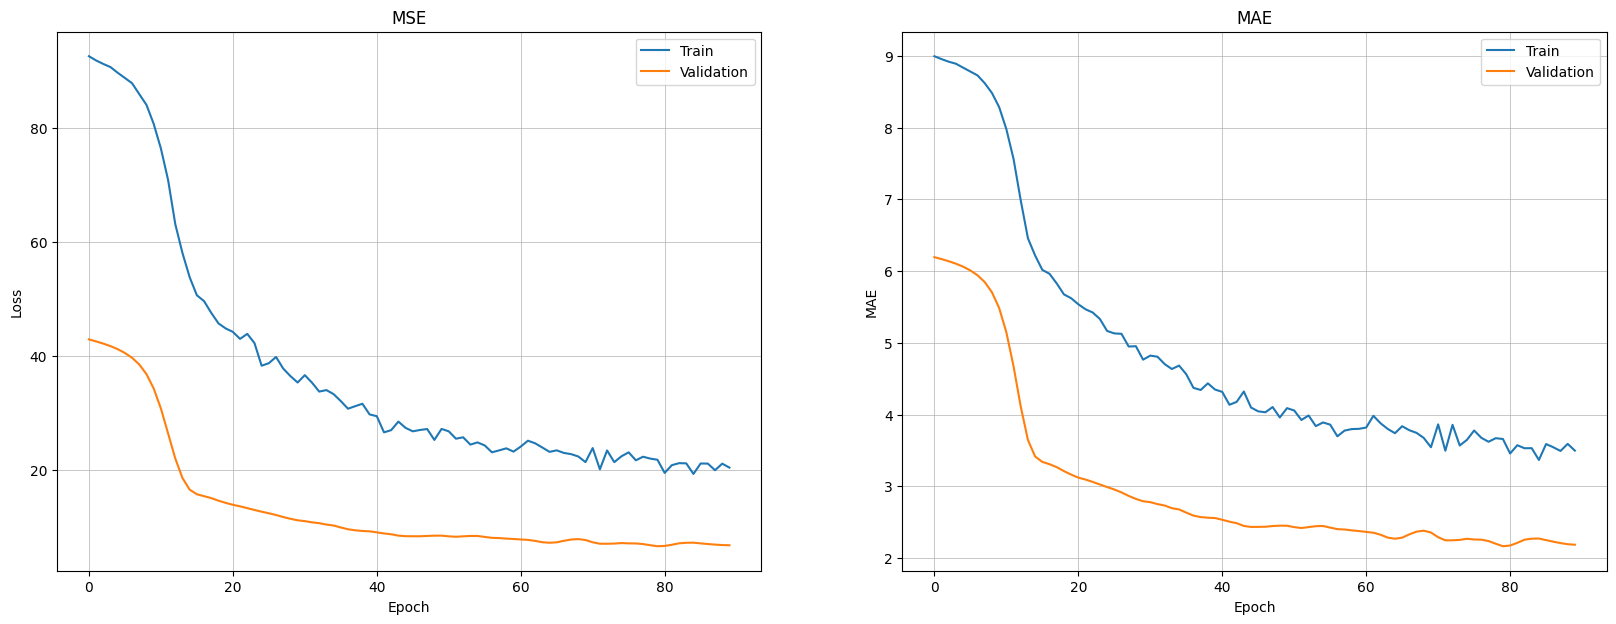

In [44]:
# Plotting the model performance
mlmodel.plot_history(history);

In [45]:
# We initialize a baseline model
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test_scaled, y_test_scaled)
res=model.evaluate(X_test_scaled,y_test_scaled)

1/1 [==============================] - 0s 474ms/step - loss: 14.1985 - mae: 3.0068


In [46]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 3.01 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 59.41 %


In [250]:
# Cross validation of the model over all of the folds
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(time_series_gcpvj0,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

8
--------------------------------------------------
MAE baseline fold n°0 = 7.33
MAE LSTM fold n°0 = 3.87
Improvement over baseline: 47.21 % 

--------------------------------------------------
MAE baseline fold n°1 = 6.59
MAE LSTM fold n°1 = 2.91
Improvement over baseline: 55.78 % 

--------------------------------------------------
MAE baseline fold n°2 = 6.62
MAE LSTM fold n°2 = 2.66
Improvement over baseline: 59.79 % 

--------------------------------------------------
MAE baseline fold n°3 = 5.83
MAE LSTM fold n°3 = 3.84
Improvement over baseline: 34.24 % 

--------------------------------------------------
MAE baseline fold n°4 = 6.24
MAE LSTM fold n°4 = 4.14
Improvement over baseline: 33.58 % 

--------------------------------------------------
MAE baseline fold n°5 = 6.22
MAE LSTM fold n°5 = 2.96
Improvement over baseline: 52.46 % 

--------------------------------------------------
MAE baseline fold n°6 = 6.2
MAE LSTM fold n°6 = 4.1
Improvement over baseline: 33.9 % 

-------

In [251]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 43.0%


In [60]:
# Creating X_i and y_i over the whole tme series
(train_final, test_final) = mlmodel.train_test_split(time_series_gcpvj0, TRAIN_TEST_RATIO, INPUT_LENGTH)
columns=train_final.columns
scaler=MinMaxScaler()
train_final=pd.DataFrame(scaler.fit_transform(train_final),columns=columns)
test_final=pd.DataFrame(scaler.transform(test_final),columns=columns)
X_train_final, y_train_final_s = mlmodel.get_X_y_strides(train_final,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test_final, y_test_final_s = mlmodel.get_X_y_strides(test_final,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
y_train_final=y_train_final_s
y_test_final=y_test_final_s
for i,y in enumerate(y_train_final_s):
    y_train_final[i]=(scaler.inverse_transform(y))
for i,y in enumerate(y_test_final_s):
    y_test_final[i]=(scaler.inverse_transform(y))
y_test_final=y_test_final.astype(int)
y_train_final=y_train_final.astype(int)


In [65]:
# Initializing the model again on the whole time series
final_model = mlmodel.init_model(X_train_final)
final_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 30)             3840      
                                                                 
 dense_30 (Dense)            (None, 6, 20)             620       
                                                                 
 dropout_20 (Dropout)        (None, 6, 20)             0         
                                                                 
 dense_31 (Dense)            (None, 6, 10)             210       
                                                                 
 dropout_21 (Dropout)        (None, 6, 10)             0         
                                                                 
 dense_32 (Dense)            (None, 6, 1)              11        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-train

In [66]:
# Training the model over the whole time series
final_model, history = mlmodel.fit_model(final_model,X_train_final,y_train_final)

Epoch 1/500
10/10 [==============================] - 4s 73ms/step - loss: 77.8179 - mae: 8.1502 - val_loss: 51.7084 - val_mae: 6.6020
Epoch 2/500
10/10 [==============================] - 0s 19ms/step - loss: 76.4959 - mae: 8.0694 - val_loss: 50.5018 - val_mae: 6.5097
Epoch 3/500
10/10 [==============================] - 0s 17ms/step - loss: 74.6934 - mae: 7.9559 - val_loss: 48.9383 - val_mae: 6.3880
Epoch 4/500
10/10 [==============================] - 0s 16ms/step - loss: 72.2925 - mae: 7.8082 - val_loss: 46.6987 - val_mae: 6.2088
Epoch 5/500
10/10 [==============================] - 0s 16ms/step - loss: 69.0431 - mae: 7.5973 - val_loss: 43.0731 - val_mae: 5.9045
Epoch 6/500
10/10 [==============================] - 0s 18ms/step - loss: 63.0923 - mae: 7.1760 - val_loss: 36.7940 - val_mae: 5.3319
Epoch 7/500
10/10 [==============================] - 0s 16ms/step - loss: 53.1690 - mae: 6.3780 - val_loss: 27.5044 - val_mae: 4.3647
Epoch 8/500
10/10 [==============================] - 0s 17ms/s

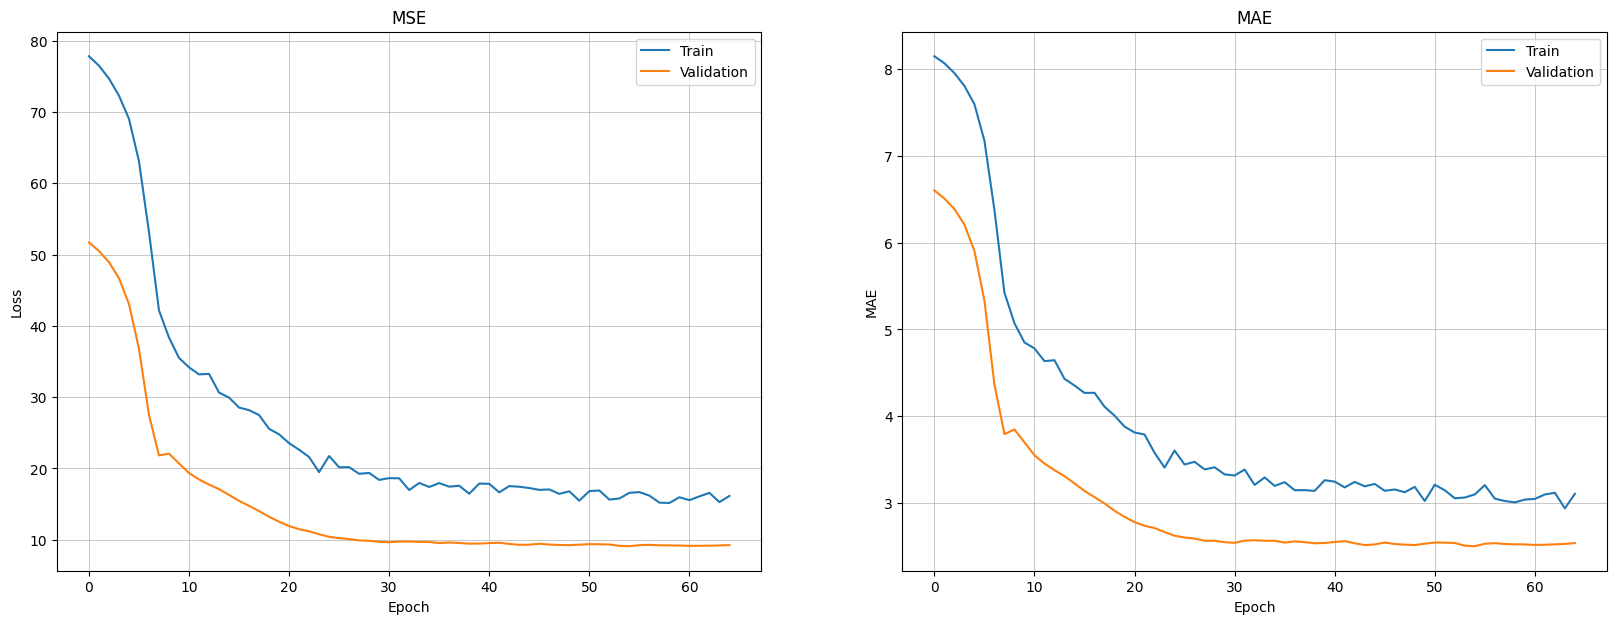

In [67]:
# Plotting the new model performance
mlmodel.plot_history(history);

In [68]:
# Initializing a baseline model over the whole time series
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test_final, y_test_final_s)
res=final_model.evaluate(X_test_final,y_test_final)
res

2/2 [==============================] - 0s 12ms/step - loss: 11.2757 - mae: 2.7488


[11.275699615478516, 2.7487878799438477]

In [69]:
# To generate the prediction for the first 6 months of 2022, we use the last six months of 2021 as input
X_end_2021_final=scaler.transform(time_series_gcpvj0.tail(6))
y_2022_final=final_model.predict([X_end_2021_final]).astype(int)
y_2022_final

1/1 [==============================] - 0s 361ms/step


array([[[6]],

       [[5]],

       [[5]],

       [[5]],

       [[5]],

       [[5]]])

In [64]:
# Save model and the last 2021 data as input for generating predictions
model.save(f'../model/gcpvj0')
np.save(os.path.join('../data',f'X_gcpvj0.npy'), X_end_2021_final)

INFO:tensorflow:Assets written to: ../model/gcpvj0/assets


INFO:tensorflow:Assets written to: ../model/gcpvj0/assets
